In [1]:
%load_ext autoreload
%autoreload 2

%matplotlib widget

import numpy as np
import matplotlib.pyplot as plt
from scipy.constants import speed_of_light

from sarpy.io.phase_history.cphd import CPHDReader

# Using CPHD by Example

CPHD conforms to the NGA Standard: NGA.STND.0068-1_1.0.1_CPHD

https://nsgreg.nga.mil/doc/view?i=4638&month=3&day=8&year=2022

Capella Spaces uses the NGA SarPy library in our processor to write the CPHD format.

https://github.com/ngageoint/sarpy

# CPHD Format

CPHD file format is a custom format developed by NGA. It consists of a file header and 3 data blocks, and optionally 1 additional data block. The file header simply points to the byte offset in the file for the start of the various data blocks. The data blocks are:

* __Signal Block__ - The complex phase history samples
* __PVP Block__ - Per-Vector-Parameters (PVP) such as position and velocity of spacecraft for each pulse
* __XML Block__ - Metadata pertaining to the entire collect. (Scene Coordinates, Reference Geometry, Channel layouts, Data Format (float, integer) and others.)
* __Support Block (optional)__ 2D Support arrays containing surface height reference and/or sampled antenna pattern (currently not in Capella CPHD)

Understanding the various blocks will help understand some of the layout of the SarPy library.

# Reading CPHD

For this example the CPHD file is from the collect: 

The STAC ID for this is: 

The location is Rosamond, CA Corner Reflector Array: https://dataverse.jpl.nasa.gov/file.xhtml?fileId=52915&version=1.0


In [2]:
# Use SarPy CPHDReader class to open a CPHD file.
# Opening it only reads the file header, so you can access the various CPHD blocks explained above.
cphd_file = "CAPELLA_C03_SP_CPHD_HH_20211017173411_20211017173436.cphd"
cphd = CPHDReader(cphd_file)

# Reading Signal Block

This is the phase history samples. Capella's CPHD is delivered in the FX (Frequency Domain), not the time domain.

Since the CPHD format is meant to be able to represent many different SAR platforms, the first thing to note is the Channel index. If you go into the XML Block, you'll find the various channels defined and their indentifiers given. For a 3 channel phased array, there may be 3 channels defined as 'forward', 'center', 'aft'. Since Capella only has a single channel, it is simply named '0'. In the following code snippets any `['0']` is referring to this channel id.

In [ ]:
# Read the entire CPHD signal into a numpy array.
# The samples are arranged as (pulses, samples)
# For whatever reason, this isn't a memmap, so be
# careful about memory usage, and this could take a while...
signal = cphd.read_signal_block()['0']

In [ ]:
# This may overwhelm your system
signal.shape

In [ ]:
signal.dtype

In [3]:
# SarPy also has a way to read smaller portions of data
pulses = (10000,14096)
samples = (2000,6096)
signal_chip = cphd.read_chip(pulses, samples)

In [13]:
# Full size of data is available
cphd.data_size[0]

(254174, 34562)

In [4]:
signal_chip.shape

(4096, 4096)

In [5]:
signal_time = np.fft.fftshift(np.fft.ifft(signal_chip, axis=1), axes=1)

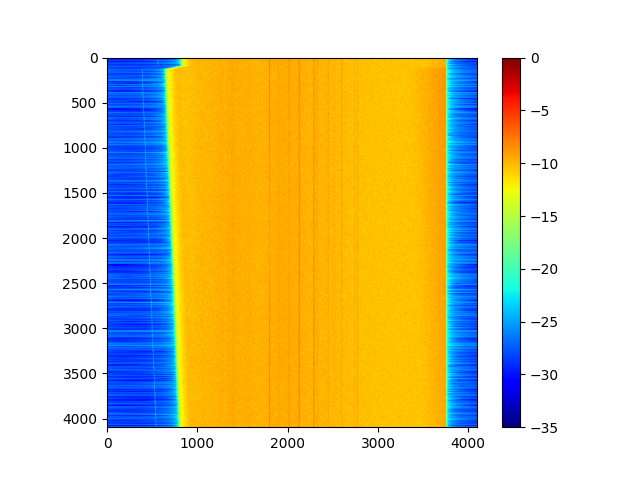

In [6]:
sta = 10 * np.log10(np.abs(signal_time))
sta = sta - np.nanmax(sta)
plt.figure()
plt.imshow(sta, vmin=-35, vmax=0.0, cmap='jet')
plt.colorbar()

In [7]:
# Compressing other dimension should produce an image focused in the center.
signal_img = np.fft.fftshift(np.fft.fft(signal_time, axis=0), axes=0)

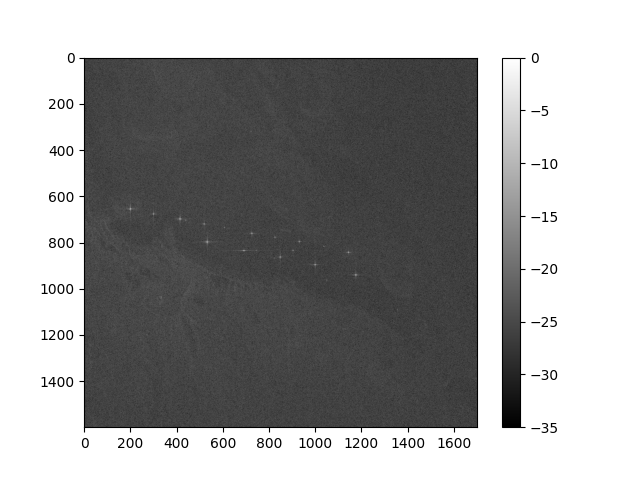

In [8]:
sti = 10 * np.log10(np.abs(signal_img))
sti = sti - np.nanmax(sti)
plt.figure()
ax = plt.imshow(sti[1200:2800, 1600:3300], cmap='gray', vmin=-35, vmax=0.0)
plt.colorbar()

# Reading PVP Block

The PVP variables are a number (or vector of numbers) for each pulse in the data. The PVP parameters we provide are listed below, and are fully defined in the CPHD spec. Providers can put in additional PVP parameters as they see fit their hardware. Capella only provides "RefTime" which is the time the center of the pulse is incident on the SRP. RefTime is discussed in the CPHD spec.

If the spec is confusing about any of theses items, please reach out to us for clarification on how we interpreted things. 

Also worth noting is that there is no "pulse offset" that needs to be maintained by the user so `TxTime[1456]` is the time `signal[1456,:]` was transmitted and `RxTime[1456]` is the time that signal was received.

Finally PVP vectors are read as a python "memmap"

```
('TxTime', np.double),        # Time CENTER of Tx pulse leaves the antenna
('TxPos', pvp_double3_dtype), # ECEF Postion at TxTime
('TxVel', pvp_double3_dtype), # ECEF Velocity at TxTime
('RcvTime', np.double),       # Time Center of Rcv window is at the antenna
('RcvPos', pvp_double3_dtype),# ECEF Position at RcvTime
('RcvVel', pvp_double3_dtype),# ECEF Position at RcvTime
('SRPPos', pvp_double3_dtype),# ECEF Position of Scene Reference Point (SRP)
('AmpSF', np.double),         # Amplitude Scale Factor (Scale factor to go from Integer to Floating point, handled by CPHD reader)
('aFDOP', np.double),         # See Spec
('aFRR1', np.double),         # See Spec
('aFRR2', np.double),         # See Spec
('FX1', np.double),           # Min frequency of Tx bandwidth retained
('FX2', np.double),           # Max frequency of Tx bandwidth retained
('FXN1', np.double),          # Min frequency of supplied bandwidth
('FXN2', np.double),          # Min frequency of supplied bandwidth
('TOA1', np.double),          # Time-of-Arrival (TOA) of first full-resolution sample
('TOA2', np.double),          # Time-of-Arrival (TOA) of last full-resolution sample
('TOAE1', np.double),         # Time-of-Arrival (TOA) of first sample
('TOAE2', np.double),         # Time-of-Arrival (TOA) of last sample
('TDTropoSRP', np.double),    # Time delay added due to Troposphere
('TDIonoSRP', np.double),     # Time delay added due to Ionosphere
('SC0', np.double),           # Start Frequency of FX Domain
('SCSS', np.double),          # Sample Spacing in Hz
('SIGNAL', np.int64),         # State of Phase Hisory / Signal Vector 0 = zeros, 1 = normal, 2 = noise, 3 = corrupt
("RefTime", np.double)        # Time center of Tx pulse arrives at SRP
```

In [9]:
# The PVP variables are read one at a time. The index 0 is for our only channel
cphd = CPHDReader(cphd_file)
tx_time = cphd.read_pvp_variable('TxTime', 0)
tx_pos = cphd.read_pvp_variable('TxPos', 0)
tx_vel = cphd.read_pvp_variable('TxVel', 0)

print(f"Tx Time Shape: {tx_time.shape} Tx Pos Shape: {tx_pos.shape} Tx Vel Shape: {tx_vel.shape}")

Tx Time Shape: (254174,) Tx Pos Shape: (254174, 3) Tx Vel Shape: (254174, 3)


# Slant Range to first sample

In [10]:
# Get slant range from Transmit position to SRP. Since the Tx position is at the center
# of the pulse, this is the slant range to the center sample.
srp = cphd.read_pvp_variable('SRPPos', 0)

slant_range_c = np.linalg.norm(srp - tx_pos, axis=1)

In [14]:
fx_ss = cphd.read_pvp_variable('SCSS', 0)  # Frequency domain sample spacing
nv = cphd.data_size[0][0]
ns = cphd.data_size[0][1]

image_width = speed_of_light / fx_ss[0]  # fx_ss is constant
range_step = image_width / ns  # TODO: Range Step is also in XML area

slant_range_0 = slant_range_c - (ns // 2 * range_step )

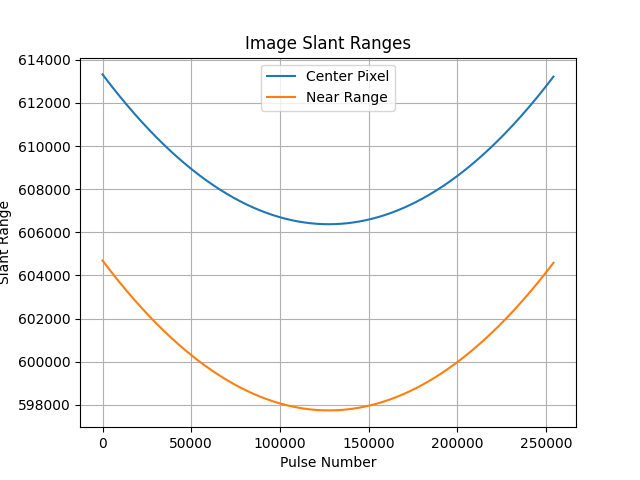

In [15]:
fig = plt.figure()
axs = plt.gca()

axs.plot(slant_range_c)
axs.plot(slant_range_0)

axs.set_title('Image Slant Ranges')
axs.set_xlabel('Pulse Number')
axs.set_ylabel('Slant Range')
axs.legend(['Center Pixel', 'Near Range'])
axs.grid()

# Azimuth Chirp

CPHD requires the removal of the Azimuth Chirp from the phase history data. The chirp is just a complex number to multiply the data by

In [16]:
# Calculate the Round-Trip-Time of each pulse
tx_time = cphd.read_pvp_variable('TxTime', 0)
rx_time = cphd.read_pvp_variable('RcvTime', 0)
rtt = rx_time - tx_time

# To calculate the Az Chirp, we need the center frequency of each pulse
fx1 = cphd.read_pvp_variable('FX1', 0)
fx2 = cphd.read_pvp_variable('FX2', 0)
fc = fx2 - fx1
assert np.all(fc)  # center frequency doesn't change in our system

az_chirp = np.exp(-1j * 2.0 * np.pi * rtt * fc)

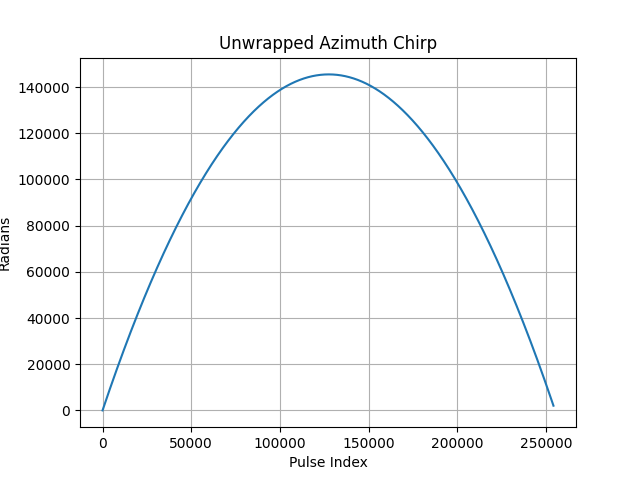

In [17]:
axs = plt.figure().gca()

axs.plot(np.unwrap(np.angle(az_chirp)))
axs.set_xlabel('Pulse Index')
axs.set_ylabel('Radians')
axs.set_title('Unwrapped Azimuth Chirp')
axs.grid()

In [18]:
# To add the Chirp back into the signal
signal = signal * az_chirp[:, None]

NameError: name 'signal' is not defined

# XML Block Metadata

There are several sections to the XML Block metadata that may be of interest. In general, everything in the XML block should be able to be calculated from the PVP variables, however sometimes its just easier to just get it from the metadata. The XML Block metadata sections are:

```
Global              # States that CPHD is in FX domain, Collection Start Time, Duration
Collection ID       # Defines Imaging Mode (SPOTLIGHT, STRIPMAP, DYNAMIC STRIPMAP) Collect ID(s)
SceneCoordinates    # Defines an Image output. Image Corner points, Imaging grid for WGS-84 tangent plane image
Data                # Defines Signal Array data type, PVP parameters, data sizes
Channel             # Defines system channel(s), indices into the channels
Dwell               # Polynomials for Center of Dwell, Dwell Time, per image grid pixel
Reference Geometry  # Defines SRP, Describes the geometry at the center of aperture (slant range, ground range, az angle, layover, twist, etc.)
Antenna             # Describes the Antenna Pattern
TxRcv               # Describes Tx/Rx waveform parameters
```

In [19]:
# Read XML metadata from the cphd file
cphd = CPHDReader(cphd_file)
meta = cphd.cphd_meta

## Scene Coordinates

In [20]:
meta.SceneCoordinates.ImageAreaCornerPoints.to_json_list()

[OrderedDict([('Lat', 34.81976887636711),
              ('Lon', -118.01583384647535),
              ('index', 1)]),
 OrderedDict([('Lat', 34.775446324555205),
              ('Lon', -118.0256892351376),
              ('index', 2)]),
 OrderedDict([('Lat', 34.78356206934416),
              ('Lon', -118.07941113424569),
              ('index', 3)]),
 OrderedDict([('Lat', 34.827888907231596),
              ('Lon', -118.06958354424735),
              ('index', 4)])]

In [21]:
cyan = meta.SceneCoordinates.ImageAreaCornerPoints[0]
blue = meta.SceneCoordinates.ImageAreaCornerPoints[1]
red = meta.SceneCoordinates.ImageAreaCornerPoints[2]
green = meta.SceneCoordinates.ImageAreaCornerPoints[3]
srp_llh = [meta.SceneCoordinates.IARP.LLH.Lat, meta.SceneCoordinates.IARP.LLH.Lon, meta.SceneCoordinates.IARP.LLH.HAE]

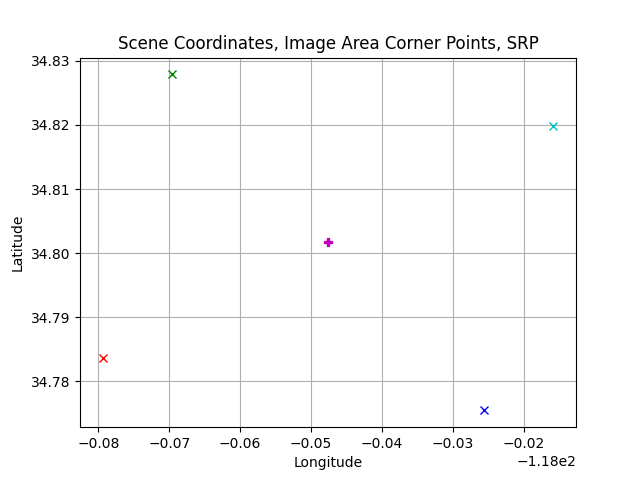

In [22]:
fig = plt.figure()
axs = fig.gca()

axs.plot(cyan.Lon, cyan.Lat, 'cx')
axs.plot(blue.Lon, blue.Lat, 'bx')
axs.plot(red.Lon, red.Lat, 'rx')
axs.plot(green.Lon, green.Lat, 'gx')

axs.plot(srp_llh[1], srp_llh[0], 'mP')

axs.set_title("Scene Coordinates, Image Area Corner Points, SRP")
axs.set_ylabel("Latitude")
axs.set_xlabel("Longitude")
axs.grid()

## Antenna Pattern

In [23]:
ant = meta.Antenna.AntPattern[0]
ant.to_dict()

OrderedDict([('Identifier', '0'),
             ('FreqZero', 9650000000.0),
             ('GainZero', 45.3),
             ('EBFreqShift', False),
             ('MLFreqDilation', False),
             ('EB',
              OrderedDict([('DCXPoly', OrderedDict([('Coefs', [0.0])])),
                           ('DCYPoly', OrderedDict([('Coefs', [0.0])]))])),
             ('Array',
              OrderedDict([('GainPoly',
                            OrderedDict([('Coefs',
                                          [[-0.19593705424955732,
                                            -2.939486876130104e-09,
                                            -60783.21642178398],
                                           [-4.5969922100560876e-10,
                                            -0.0011477073220022335,
                                            -2.9374911071204946e-08],
                                           [-60512.76067670803,
                                            -3.046417539476009

In [24]:
G = ant.GainZero
G

45.3

In [25]:
gain_poly = ant.Array.GainPoly.Coefs

In [26]:
gain_poly

array([[-1.95937054e-01, -2.93948688e-09, -6.07832164e+04],
       [-4.59699221e-10, -1.14770732e-03, -2.93749111e-08],
       [-6.05127607e+04, -3.04641754e-08,  2.27680145e+08]])

In [27]:
# nominal beamwidth is 0.7 deg
bw = np.deg2rad(0.9 / 2.0)
azimuth_pts = np.linspace(-bw, bw, 101)
elevation_pts = np.linspace(-bw, bw, 101)

In [28]:
azimuth_pts, elevation_pts = np.meshgrid(azimuth_pts, elevation_pts)
dcx = np.cos(np.pi / 2 - azimuth_pts)
dcy = np.cos(np.pi / 2 - elevation_pts)

In [29]:
pat = np.polynomial.polynomial.polyval2d(x=dcx,
                                         y=dcy,
                                         c=gain_poly)

Text(0.5, 0, 'Gain (dB)')

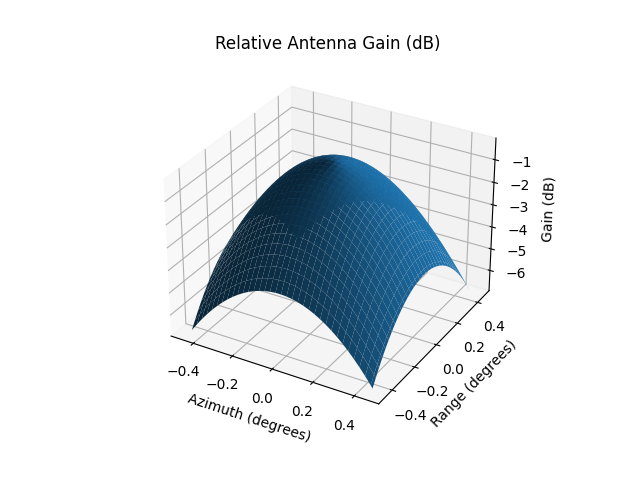

In [30]:
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.plot_surface(np.rad2deg(dcy), np.rad2deg(dcx), pat)
ax.set_title("Relative Antenna Gain (dB)")
ax.set_xlabel("Azimuth (degrees)")
ax.set_ylabel("Range (degrees)")
ax.set_zlabel("Gain (dB)")

# Chirp Rate

In [31]:
# Transmit Pulse Length
Tp = meta.TxRcv.TxWFParameters[0].PulseLength
# Tx Chirp Rate
Kr = meta.TxRcv.TxWFParameters[0].LFMRate

bw_rf = meta.TxRcv.TxWFParameters[0].RFBandwidth

In [33]:
bw_rf

500000000.0

In [34]:
bandwidth = Kr * Tp
bandwidth

500000000.0

In [35]:
polarization = f"{meta.TxRcv.TxWFParameters[0].Polarization}{meta.TxRcv.RcvParameters[0].Polarization}"
polarization

'HH'

# Metadata has things in multiple places, and things that you can calculate from PVPs

In [36]:
# polarization
meta.Channel.Parameters[0].Polarization.TxPol

'H'

In [37]:
meta.Channel.Parameters[0].Polarization.RcvPol

'H'

In [38]:
# Tx Bandwidth
meta.Channel.Parameters[0].FxBW

499982638.8888893

In [39]:
# Center Frequency
meta.Channel.Parameters[0].FxC

9649991191.444445